In [36]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [37]:
# ================== Dataset Class ==================
class CarlaDataset(Dataset):
    def __init__(self, images, angles, signals, transform=None):
        self.images = images
        self.angles = angles
        self.signals = signals
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # (3, 224, 224)
        angle = self.angles[idx]
        signal = self.signals[idx]

        if self.transform:
            img = self.transform(img)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(signal).unsqueeze(0), torch.tensor(angle)

In [ ]:
# ================== Model ==================
class SteeringModel(nn.Module):
    def __init__(self):
        super(SteeringModel, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-1])  # Output: (B, 512, 1, 1)

        self.signal_fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU()
        )

        self.combined_fc = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, signal):
        x = self.cnn_backbone(image)  # (B, 512, 1, 1)
        x = x.view(x.size(0), -1)     # (B, 512)
        s = self.signal_fc(signal)   # (B, 32)
        combined = torch.cat([x, s], dim=1)  # (B, 544)
        out = self.combined_fc(combined)     # (B, 1)
        return out.squeeze(1)  # (B,)

In [39]:
# ================== Load Data ==================
images = np.load('../output/new_images.npy')         # (N, 3, 224, 224)
angles = np.load('../output/new_angles.npy').astype(np.float32)
signals = np.load('../output/new_turn_signals.npy').astype(np.float32)

train_idx, val_idx = train_test_split(np.arange(len(images)), test_size=0.2, random_state=42)

train_data = (images[train_idx], angles[train_idx], signals[train_idx])
val_data = (images[val_idx], angles[val_idx], signals[val_idx])

In [40]:
# ================== Transforms ==================
transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0),  # Scale from [0, 255] to [0.0, 1.0]
    transforms.ToTensor(),  # Redundant if already tensor format, but kept for safety
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [41]:
# ================== Dataloaders ==================
train_dataset = CarlaDataset(*train_data, transform=transform)
val_dataset = CarlaDataset(*val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# ================== Training Setup ==================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SteeringModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)
criterion = nn.MSELoss()

train_losses = []
val_losses = []
best_val_loss = float('inf')

c:\Users\Pravin\anaconda3\envs\ACS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pravin\anaconda3\envs\ACS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
# ================== Training Loop ==================
for epoch in range(10):
    model.train()
    total_train_loss = 0
    for images, signals, angles in train_loader:
        images, signals, angles = images.to(device), signals.to(device), angles.to(device)

        optimizer.zero_grad()
        preds = model(images, signals)
        loss = criterion(preds, angles)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === Validation ===
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, signals, angles in val_loader:
            images, signals, angles = images.to(device), signals.to(device), angles.to(device)
            preds = model(images, signals)
            loss = criterion(preds, angles)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_steering_model.pth")


C:\Users\Pravin\AppData\Local\Temp\ipykernel_6252\2607652348.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(signal).unsqueeze(0), torch.tensor(angle)


Epoch 1 | Train Loss: 0.0047 | Val Loss: 0.0016
Epoch 2 | Train Loss: 0.0013 | Val Loss: 0.0012
Epoch 3 | Train Loss: 0.0009 | Val Loss: 0.0010
Epoch 4 | Train Loss: 0.0006 | Val Loss: 0.0012
Epoch 5 | Train Loss: 0.0006 | Val Loss: 0.0010
Epoch 6 | Train Loss: 0.0005 | Val Loss: 0.0009
Epoch 7 | Train Loss: 0.0005 | Val Loss: 0.0009
Epoch 8 | Train Loss: 0.0005 | Val Loss: 0.0016
Epoch 9 | Train Loss: 0.0004 | Val Loss: 0.0010
Epoch 10 | Train Loss: 0.0005 | Val Loss: 0.0015


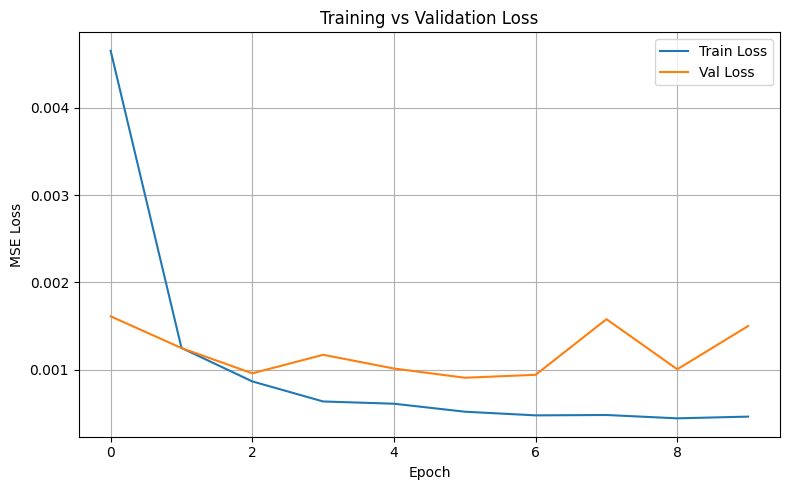

In [44]:
# ================== Plot Learning Curves ==================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curves.png")
plt.show()